<h1 style="text-align:center;"> Clustered Genetic Algorithm </h1>

<h4>Massimo Montanaro</h4>

<p> Let's see how the CLustered Genetic Algorithm proposed in the notebook 'Around the world with genetic algorithms' works. the goal was to compare two algorithms, Standard (SGA) and Clustered (CGA). used in the resolution of the Traveler Salesman Problem. We have seen how with a large number of points to cross the EMS does not get excellent results as the sample space is given by the simple permutation of the points, that is the factorial of the total number of points. the CGA greatly reduces the number of possible combinations by creating subgroups of points very close to each other, ensuring not to generate paths that provide a connection between one point and another one that is very distant if there are others closer to the first. Since it is possible to find many sources on how the first algorithm works (here called Standard), here we focus on the step by step explanation of the CGA on a toy example. </p>

<p> <i>In this notebook I will very often and repeatedly transform the same tables into np.array and pd.DataFrame. This doesn't sound very good for running time optimization, but the goal is to show how the algorithm works. When the tables are printed, these are more readable if transformed into pd.DataFrame. </i></p>

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
np.random.seed(0)

<p> Here we define the coordinates of some toy points. Sometimes for a more compact view I will print the dataframes with the number of columns much smaller than the number of rows in their transposed form (dataframe.T), inverting the columns with the rows. </p>

In [2]:
points = pd.DataFrame([[5,3],[12,9],[2,7],[10,4],[9,3],
                       [6,1],[11,8],[2,9],[3,10],[1,7],
                       [10,10],[4,1],[3,2],[11,7],[4,3],[11,2]])
points.columns = ['X', 'Y']
points.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
X,5,12,2,10,9,6,11,2,3,1,10,4,3,11,4,11
Y,3,9,7,4,3,1,8,9,10,7,10,1,2,7,3,2


<p> Visualize points </p>

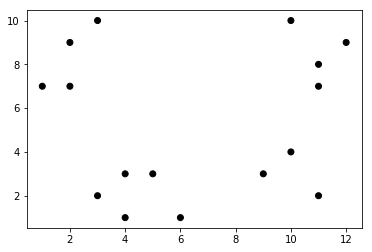

In [3]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(points.iloc[:,0], points.iloc[:,1], c = ['#000000' for _ in range(points.shape[0])])

<p>At a glance we can see how the points can be grouped into 4 clusters. In fact, the first function we need is that which from a coordinate dataframe gives us a label belonging to a cluster and a name for each point. Here for simplicity the name of each point will be the row index where that point is expressed in coordinates.</p>

In [4]:
def _cga_clustering(data, n_clusters):
    
    # 1 #
    
    '''
        Input:
        - data must be a pd.DataFrame with only 2 columns ['X', 'Y']
        - n_clusters must be integer
    '''
    
    clust_data = np.array(data)
    
    # set the number of desired cluster and the seed
    km = KMeans(n_clusters = n_clusters,
               random_state = 0)
    
    # assign predicted labels 
    labeled_data = km.fit_predict(clust_data)
    # create new dataframe
    clustered_data = pd.DataFrame([data.index,
                                   labeled_data, 
                                   clust_data[:,0], 
                                   clust_data[:,1]]).T
    clustered_data.columns = ['Index','Cluster', 'X', 'Y']
    
    # return a  pandas dataframe
    return clustered_data

In [5]:
clustered_data = _cga_clustering(points, 4)
clustered_data.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0,1,2,3,3,0,1,2,2,2,1,0,0,1,0,3
X,5,12,2,10,9,6,11,2,3,1,10,4,3,11,4,11
Y,3,9,7,4,3,1,8,9,10,7,10,1,2,7,3,2


<p> Visualize cluster with different colors </p>

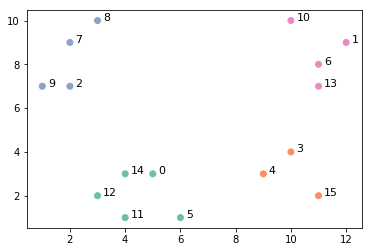

In [6]:
colors = ['#6AC1A6', '#E68CC2', '#8EA1CA', '#FA8D67']
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(clustered_data.iloc[:,2], clustered_data.iloc[:,3], c = [colors[i] for i in clustered_data.iloc[:,1].tolist()])

x = [i for i in clustered_data.iloc[:,2]]
y = [i for i in clustered_data.iloc[:,3]]
for i in range(clustered_data.shape[0]):
    ax.annotate(str(clustered_data.iat[i,0]), (x[i]+0.2, y[i]), color='black', fontsize = 11)

<p> We create a table in which for each label of the clusters there is associated a weight initially set to 1. The weight is used to calculate the probability that each cluster has to be selected first. The way the probability for the <i>cluster (i)</i> is calculated is: weight of the <i>cluster (i)</i> divided by the sum of the weights of all clusters.</p>

In [7]:
def _cga_probability_start_table(clustered_data):
    
    # 2 #
    
    # retrieve number of clusters
    n_clusters = np.unique(clustered_data.iloc[:,1].tolist()).shape[0]
    # create empty table
    start_table = np.zeros((n_clusters,2))
    
    # fill with clusteres lables and weights
    start_table[:,0] = np.arange(0, n_clusters, 1)
    start_table[:,1] = np.ones((n_clusters))
    
    # return pandas dataframe
    start_table = pd.DataFrame(start_table)
    start_table.columns = ['Cluster Labels', 'Weights']
    
    return start_table

In [8]:
start_table = _cga_probability_start_table(clustered_data)
start_table

,Cluster Labels,Weights
0,0.0,1.0
1,1.0,1.0
2,2.0,1.0
3,3.0,1.0


<p>Now we create a probability table (a 3 column dataframe). In the first column ('From'), the label of each cluster is repeated as many times as the other clusters. In the second column ('To'), the labels of the other clusters other than the one in the first column are shown row by row. In this way we created all the possibilities to reach all the other clusters after choosing which one to start from. In the third column ('Weights') there is a weight initially set at 1.</p>

In [9]:
def _cga_clusters_probability_table(clustered_data):
    
    # 3 #
    
    # retrieve labels
    cluster_labels = np.unique(clustered_data.iloc[:,1].tolist())
    # create empty table
    probability_table = np.zeros((len(cluster_labels)*(len(cluster_labels)-1),3))
    
    # row is a counter for iterate over rows
    row = 0
    # iterate over labels
    for label in cluster_labels:
        # save other labels
        other_labels = cluster_labels[cluster_labels != label]
        # iterate over other labels
        for other_label in other_labels:
            # assign the label to the first column ('From'),
            probability_table[row,0] = label
            # the other label to the second one ('To') 
            probability_table[row,1] = other_label
            # and an initial value of 1 to the third one ('Weight')
            probability_table[row,2] = 1
            # update row
            row += 1
    
    # return a pandas dataframe
    probability_table = pd.DataFrame(probability_table)
    probability_table.columns = ['From', 'To', 'Weights']
    
    return probability_table

In [10]:
probability_table = _cga_clusters_probability_table(clustered_data)
probability_table.T

,0,1,2,3,4,5,6,7,8,9,10,11
From,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0
To,1.0,2.0,3.0,0.0,2.0,3.0,0.0,1.0,3.0,0.0,1.0,2.0
Weights,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<p>Now let's create a list of probability tables. this list contains a table for each cluster. The tables follow the same scheme described previously ('From', 'To' and 'Weights') but this table does not contain information on the succession of clusters but from the points within the same cluster.</p>

In [11]:
def _cga_path_probability_list(clustered_data):
    
    # 4 #
    
    # retrieve number of clusters
    n_clusters = np.unique(clustered_data.iloc[:,1].tolist())
    # define columns names
    colnames = ['From', 'To', 'Weights']
    
    probability_list = []
    
    # iterate over clusters labels
    for cluster in n_clusters:
        # extract points belonging to the cluster
        sub_data = clustered_data[clustered_data[clustered_data.columns[1]] == cluster]
        # extract points labels
        points = np.array(sub_data.iloc[:,0].tolist())
        weights = []
        # iterate over points in the same cluster
        for point in points:
            # save other points in the same cluster
            other_points= points[points != point]
            # iterate over other points in the same cluster
            for other_point in other_points:
                # save 'from', 'to' and 'weights' 
                weights.append([point, other_point, float(1)])
            # dataframe
        weights = pd.DataFrame(weights)
        weights.columns = colnames
        # append table for each cluster
        probability_list.append(weights)
    
    # return a list of pandas dataframes
    return probability_list

In [12]:
probability_list = _cga_path_probability_list(clustered_data)
# let's see a random table 
probability_list[np.random.choice(np.unique(clustered_data.iloc[:,1]))].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
From,0.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,11.0,11.0,11.0,11.0,12.0,12.0,12.0,12.0,14.0,14.0,14.0,14.0
To,5.0,11.0,12.0,14.0,0.0,11.0,12.0,14.0,0.0,5.0,12.0,14.0,0.0,5.0,11.0,14.0,0.0,5.0,11.0,12.0
Weights,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<p> Now we can generate a random path and we have two ways to do it, we can generate it by taking into account the weights or by randomly extracting the clusters and points with a uniform distribution. Obviously now the two methods correspond because the weights are all set to 1, leading to a uniform distribution, but when we update the weights the two methods will return different results. </p>

In [13]:
def _cga_generate_random_sequence(probability_table, start_table = None, weights = False):
    
    # 5 #
    
    '''
        Input:
        - probability_table (and eventually start_table) must be pd.DataFrame;
        - weights must be True or False.
    '''
    
    choosed = []
    # retrieve clusters labels
    cluster_labels = np.unique(probability_table.iloc[:,0])
    
    # if we don't want to sample with weigths
    if start_table is None:
        # the first cluster is simply chosen with a uniform distribution from all the clusters
        start = np.random.choice(cluster_labels, 1, replace = False)[0]
        
    # if we want to sample with weights
    else:
        # calculate the probability of being selected for all cluster from their weights
        probs = np.array(start_table.iloc[:,1])/np.sum(start_table.iloc[:,1])
        # sample the first cluster with weights
        start = np.random.choice(np.array(start_table.iloc[:,0]), 1, replace = False, p = probs)[0]
        
    next_cluster = start
    
    while True:
        # append the sampled cluster
        choosed.append(int(next_cluster))
        # if the length of the list is equal to the total number of clusters
        if len(choosed) == cluster_labels.shape[0]:
            # stop
            break
        # else    
        else:
            # find other not sampled clusters
            other = np.array([i for i in cluster_labels if i not in choosed])
            # select from probability_table only that rows in which the first column is equal to the last cluster selected
            next_prob_table = probability_table[probability_table[probability_table.columns[0]] == next_cluster]
            # select from the filtered probability_table only that rows in which the cluster in the second column is not in 'choosed'
            only_possible_next = np.array([[next_prob_table.iat[i,1], next_prob_table.iat[i,2]] for i in range(next_prob_table.shape[0]) if next_prob_table.iat[i,1] not in choosed], dtype = float)
            # if we want to sample next cluster without weights
            if weights != True:
                # update next_cluster with the new sampled cluster
                next_cluster = np.random.choice(only_possible_next[:,0], 1, replace = False)[0]
            # if we want to sample with weigths
            else:
                # calculate the probability of being selected for all cluster from their weights
                probs = only_possible_next[:,1]/np.sum(only_possible_next[:,1])
                # update next_cluster with the new sampled cluster
                next_cluster = np.random.choice(only_possible_next[:,0], 1, replace = False, p = probs)[0]
    
    # return a list with the sequence of cluster
    return choosed         

<p>Let's see how this function work and so we rewrite the same function by having the various steps printed</p>

In [14]:
def _print_generate_random_sequence(probability_table, start_table = None, weights = False):
    
    # this function is equal to the previous one but this prints its work #
    
    choosed = []
    # retrieve clusters labels
    cluster_labels = np.unique(probability_table.iloc[:,0])
    
    # if we don't want to sample with weigths
    if start_table is None:
        # the first cluster is simply chosen with a uniform distribution from all the clusters
        start = np.random.choice(cluster_labels, 1, replace = False)[0]
        
        # print some information just for demonstration
        print('\tSTART')
        print('The randomly sampled starting cluster without weights is {}'.format(int(start)))
    
    # if we want to sample with weights
    else:
        # calculate the probability of being selected for all cluster from their weights
        probs = np.array(start_table.iloc[:,1])/np.sum(start_table.iloc[:,1])
        # sample the first cluster with weights
        start = np.random.choice(np.array(start_table.iloc[:,0]), 1, replace = False, p = probs)[0]
        
        # print some information just for demonstration
        start_prob = probs[int(start)]
        print('\tSTART')
        print('The current weights are: ')
        print(start_table)
        print('\nThe vector of probabilities calculated from the weights is: ')
        print(probs)
        print('\nThe randomly sampled starting cluster with weights is {}'.format(int(start)) + ' (prob = ' + str(np.round(start_prob, 3)) + ')')
        # print some information just for demonstration
        print('\nThe current weights are: ')
        print(probability_table)
    next_cluster = start
    
    
    while True:
        # append the sampled cluster
        choosed.append(int(next_cluster))
        # if the length of the list is equal to the total number of clusters
        if len(choosed) == cluster_labels.shape[0]:
            # stop
            print('\n\tEND')
            print('The random cluster sequence is {}'.format(choosed))
            break
        # else    
        else:
            # find other not sampled clusters
            other = np.array([i for i in cluster_labels if i not in choosed])
            # select from probability_table only that rows in which the first column is equal to the last cluster selected
            next_prob_table = probability_table[probability_table['From'] == next_cluster]
            # select from the filtered probability_table only that rows in which the cluster in the second column is not in 'choosed'
            only_possible_next = np.array([[next_prob_table.iat[i,1], next_prob_table.iat[i,2]] for i in range(next_prob_table.shape[0]) if next_prob_table.iat[i,1] not in choosed], dtype = float)
            # if we want to sample next cluster without weights
            if weights != True:
                # update next_cluster with the new sampled cluster
                next_cluster = np.random.choice(only_possible_next[:,0], 1, replace = False)[0]
                
                # print some information just for demonstration
                print('\n\tNEXT')
                print('The randomly sampled starting cluster without weights is {}'.format(int(next_cluster)))
            # if we want to sample with weigths
            else:
                
                # calculate the probability of being selected for all cluster from their weights
                probs = only_possible_next[:,1]/np.sum(only_possible_next[:,1])
                # update next_cluster with the new sampled cluster
                next_cluster = np.random.choice(only_possible_next[:,0], 1, replace = False, p = probs)[0]
                
                # print some information just for demonstration
                next_prob = probs[list(only_possible_next[:,0]).index(next_cluster)]
                print('\n\tNEXT')
                print('Choosed clusters:')
                print(choosed)
                
                print('\nNext possible clusters and weights from cluster {} that have not yet been selected are:'.format(choosed[len(choosed)-1]))
                only_possible_next = pd.DataFrame(only_possible_next)
                only_possible_next.columns = probability_table.columns[1:]
                only_possible_next.index = [str(choosed[len(choosed)-1]) for _ in range(only_possible_next.shape[0])]
                print(only_possible_next)
                print('\nThe vector of probabilities calculated from the weights is: ')
                print(probs)
                print('\nThe randomly sampled next cluster with weights is {}'.format(int(next_cluster)) + ' (prob = ' + str(np.round(next_prob, 3)) + ')')       

<p> With uniform distribution </p>

In [15]:
_print_generate_random_sequence(probability_table = probability_table)

	START
The randomly sampled starting cluster without weights is 2

	NEXT
The randomly sampled starting cluster without weights is 0

	NEXT
The randomly sampled starting cluster without weights is 1

	NEXT
The randomly sampled starting cluster without weights is 3

	END
The random cluster sequence is [2, 0, 1, 3]


<br>
<p> Taking into account weigths </p>

In [16]:
_print_generate_random_sequence(probability_table = probability_table, start_table = start_table, weights = True)

	START
The current weights are: 
   Cluster Labels  Weights
0             0.0      1.0
1             1.0      1.0
2             2.0      1.0
3             3.0      1.0

The vector of probabilities calculated from the weights is: 
[0.25 0.25 0.25 0.25]

The randomly sampled starting cluster with weights is 1 (prob = 0.25)

The current weights are: 
    From   To  Weights
0    0.0  1.0      1.0
1    0.0  2.0      1.0
2    0.0  3.0      1.0
3    1.0  0.0      1.0
4    1.0  2.0      1.0
5    1.0  3.0      1.0
6    2.0  0.0      1.0
7    2.0  1.0      1.0
8    2.0  3.0      1.0
9    3.0  0.0      1.0
10   3.0  1.0      1.0
11   3.0  2.0      1.0

	NEXT
Choosed clusters:
[1]

Next possible clusters and weights from cluster 1 that have not yet been selected are:
    To  Weights
1  0.0      1.0
1  2.0      1.0
1  3.0      1.0

The vector of probabilities calculated from the weights is: 
[0.33333333 0.33333333 0.33333333]

The randomly sampled next cluster with weights is 0 (prob = 0.333)

	NEX

<p> For now, using weights or not, leads to the same kind of results. In fact, both <i>probability_table</i> and <i>start_table</i> are initially created with all the weights set to 1 and have never been updated (they will be updated later). So in both cases the sampling follows a uniform distribution.</p>

<p>This does not mean that the two methods now return the same path to us, but that if we extracted cluster sequences a number of times with both methods we would observe that all clusters occur after a certain cluster with the same frequency. If the weights were all different we would observe a higher frequency for those clusters with a higher weight.</p>

<p> This type of work is also used for the generation of point sequences contained in the same cluster.</p>

In [17]:
def _cga_create_path(probability_table, probability_list, start_table = None, weights = False):
    
    # 6 #
    
    '''
        Input:
        - probability_table (and eventually start_table) must be pd.DataFrame;
        - probability_list must be a list of pd.DataFrame
        - weights must be True or False.
    '''
    
    # create cluster path
    # N.B. function 5: _cga_generate_random_sequence()
    cluster_path = np.array(_cga_generate_random_sequence(probability_table, start_table = start_table, weights=weights), dtype=float)
    
    path = []
    # iterate over clusters
    for i in cluster_path:
        # N.B. function 5: _cga_generate_random_sequence()
        # the same function is used for generate the sequence of points in the same cluster
        path.append(_cga_generate_random_sequence(pd.DataFrame(probability_list[int(i)]), weights=weights))
    
    # and then concatenate each sequence of points    
    path = pd.DataFrame([item for subpath in path for item in subpath])
    path.columns = ['Points Path']
    
    cluster_path = pd.DataFrame(cluster_path)
    cluster_path.columns = ['Cluster Path']
    
    # cluster_path, path are pd.DataFrame
    return cluster_path, path

In [18]:
cluster_path, path = _cga_create_path(probability_table, probability_list)
cluster_path.T

,0,1,2,3
Cluster Path,0.0,2.0,1.0,3.0


In [19]:
path.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Points Path,11,12,14,0,5,7,9,2,8,1,13,6,10,3,15,4


<p>Now we create a function that calculate euclidean distance between two points</p>

In [20]:
def _cga_find_distance(point_1, point_2, clustered_data):
    
    # 7 #
    
    '''
        point_1 and point_2 must be integer
    '''
    
    # extract coordinates value for point_1
    x_point_1 = clustered_data[clustered_data[clustered_data.columns[0]] == point_1].iat[0,2]
    y_point_1 = clustered_data[clustered_data[clustered_data.columns[0]] == point_1].iat[0,3]
    
    # extract coordinates value for point_2
    x_point_2 = clustered_data[clustered_data[clustered_data.columns[0]] == point_2].iat[0,2]
    y_point_2 = clustered_data[clustered_data[clustered_data.columns[0]] == point_2].iat[0,3]
    
    # compute euclidean distance
    xdistance = abs(x_point_1 - x_point_2)
    ydistance = abs(y_point_1 - y_point_2)
    
    distance = np.sqrt((xdistance**2) + (ydistance**2))
    
    # return a scalar
    return distance

<p>If we iterate this function over a sequence and then sum all the results we find the total length of the path</p>

In [21]:
# example of _cga_find_distance()
sum([_cga_find_distance(path.iat[i,0], path.iat[i+1,0], clustered_data) for i in range(path.shape[0]-1)])

46.40676969804987

<p>Here we parallel the generation of sequences, creating a population of paths.</p>

In [22]:
def _cga_create_population(probability_table, probability_list, size, start_table = None, weights = False):
    
    # 8 #
    
    '''
        Input:
        - size must be an integer
    '''
    
    # create cluster path and points path
    # N.B. function 6: _cga_create_path()
    clust_path, path = _cga_create_path(probability_table, probability_list, start_table = start_table, weights = weights)
    # create an empty array for cluster path population
    clust_pop = np.zeros((clust_path.shape[0], size), dtype = int)
    clust_pop[:,0] = np.array(clust_path.iloc[:,0])
    
    # create an empty array for points path population
    population = np.zeros((path.shape[0],size), dtype = int)
    population[:,0] = np.array(path.iloc[:,0])
    
    # create cluster path and points path *size* times
    # N.B. function 6: _cga_create_path() 
    for i in range(1,size):
        clust_pop_temp, population_temp = _cga_create_path(probability_table, probability_list, start_table = start_table, weights = weights)
        clust_pop[:,i], population[:,i] = np.array(clust_pop_temp.iloc[:,0]), np.array(population_temp.iloc[:,0])
    
    clust_pop = pd.DataFrame(clust_pop)
    clust_pop.columns = ['Ind_' + str(i) for i in range(size)]
    
    population = pd.DataFrame(population)
    population.columns = ['Ind_' + str(i) for i in range(size)]
    # clust_pop and population are pd.DataFrame
    return clust_pop, population

In [23]:
clust_pop, population = _cga_create_population(probability_table, probability_list, size = 10, start_table=start_table, weights=True)

In [24]:
clust_pop

,Ind_0,Ind_1,Ind_2,Ind_3,Ind_4,Ind_5,Ind_6,Ind_7,Ind_8,Ind_9
0,2,0,0,2,3,0,3,3,2,1
1,1,2,2,0,1,3,2,2,1,3
2,0,3,1,3,2,1,0,1,0,0
3,3,1,3,1,0,2,1,0,3,2


In [25]:
population

,Ind_0,Ind_1,Ind_2,Ind_3,Ind_4,Ind_5,Ind_6,Ind_7,Ind_8,Ind_9
0,7,5,0,2,15,5,3,3,7,13
1,2,12,11,9,3,12,4,4,9,1
2,8,11,12,7,4,14,15,15,2,10
3,9,0,5,8,1,0,8,2,8,6
4,10,14,14,5,13,11,2,7,1,15
5,13,2,8,12,6,3,7,8,10,4
6,6,8,7,0,10,15,9,9,6,3
7,1,7,9,14,9,4,12,13,13,11
8,14,9,2,11,2,6,0,10,12,0
9,0,15,6,15,7,10,5,6,5,5


<p>It is important to keep in mind that this population is made up of the names of the points that we will use as pointers to retrieve their coordinates from <i>clustered_data</i></p>

<p>Now we can evaluate our population of paths and order them in increasing order by their fit (i.e. the length of the path)</p>

In [26]:
def _cga_evaluate_population(clust_pop, population, clustered_data):
    
    # 9 #
    
    fitness_list = []
    
    # iterate over individuals
    for i in range(population.shape[1]):
        # assign individual[i] to path
        path = np.array(population.iloc[:,i])
        # evaluate path's length
        # N.B. function 7: _cga_find_distance()
        length = np.sum([_cga_find_distance(path[x], path[x+1], clustered_data) for x in range(path.shape[0]-1)])
        # append length
        fitness_list.append(length)
    
    # order indices of individuals (min to max)
    ordered_ind = np.argsort(fitness_list)
    
    # use ordered indices to arrange in an increasing sense clust_pop
    ordered_clust_pop = clust_pop.iloc[:,ordered_ind]
    # use ordered indices to arrange in an increasing sense population
    ordered_population = population.iloc[:,ordered_ind]
    # save the best length
    best_fitness = fitness_list[ordered_ind[0]]
    
    # return: best_fitness as scalare 
    #return ordered_clust_pop and ordered_population as pd.DataFrame
    return best_fitness, ordered_clust_pop, ordered_population

In [27]:
best_fitness, ordered_clust_pop, ordered_population = _cga_evaluate_population(clust_pop, population, clustered_data)

In [28]:
best_fitness

44.11411027191863

In [29]:
ordered_clust_pop

,Ind_3,Ind_4,Ind_1,Ind_9,Ind_8,Ind_2,Ind_0,Ind_5,Ind_6,Ind_7
0,2,3,0,1,2,0,2,0,3,3
1,0,1,2,3,1,2,1,3,2,2
2,3,2,3,0,0,1,0,1,0,1
3,1,0,1,2,3,3,3,2,1,0


In [30]:
ordered_population

,Ind_3,Ind_4,Ind_1,Ind_9,Ind_8,Ind_2,Ind_0,Ind_5,Ind_6,Ind_7
0,2,15,5,13,7,0,7,5,3,3
1,9,3,12,1,9,11,2,12,4,4
2,7,4,11,10,2,12,8,14,15,15
3,8,1,0,6,8,5,9,0,8,2
4,5,13,14,15,1,14,10,11,2,7
5,12,6,2,4,10,8,13,3,7,8
6,0,10,8,3,6,7,6,15,9,9
7,14,9,7,11,13,9,1,4,12,13
8,11,2,9,0,12,2,14,6,0,10
9,15,7,15,5,5,6,0,10,5,6


<p> We can easily check that the best individual <i>(Ind_3)</i> doesn't seem approximate the shortest path. However its combination of genes in this population is the best. 
So let's update the chances that genes have to be extracted after others have already been extracted. To do this we will use the best individuals to increase the weights of our probability tables, while the worst individuals will decrease the weights. 
Iterating this process several times we should be able to approximate the shortest path. </p>

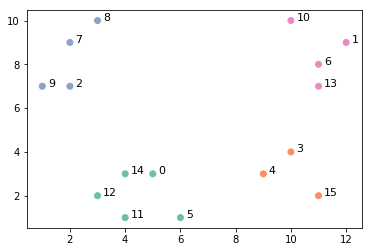

In [31]:
colors = ['#6AC1A6', '#E68CC2', '#8EA1CA', '#FA8D67']
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(clustered_data.iloc[:,2], clustered_data.iloc[:,3], c = [colors[i] for i in clustered_data.iloc[:,1].tolist()])

x = [i for i in clustered_data.iloc[:,2]]
y = [i for i in clustered_data.iloc[:,3]]
for i in range(clustered_data.shape[0]):
    ax.annotate(str(clustered_data.iat[i,0]), (x[i]+0.2, y[i]), color='black', fontsize = 11)

<p>Now we update the weights, with the same function we can increase or decrease.</p>

In [32]:
def _cga_update(clust_path, path, start_table, probability_table, probability_list, update_value):
    
    # 10 #
    
    '''
        Input:
        - clust_path is a cluster path from the population (best or worst, i.e. one of the first columns of ordered_clust_pop or one of the last ones)
        - path is a path from the population (best or worst, i.e. one of the first columns of ordered_population or one of the last ones)
    '''
    
    # transform in np.array
    clust_path = np.array(clust_path, dtype = int)
    path = np.array(path, dtype = int)
    
    # UPDATE START_TABLE
    # here we update the weights of the first cluster label extract in clust_path
    start_table.iat[clust_path[0],1] = start_table.iat[clust_path[0],1] * update_value
    
    # UPDATE PROBABILITY_TABLE
    # iterate over all the clusters in the path
    for i in range(clust_path.shape[0]-1):
            
        # find all the rows  that match the cluster [i] in the first column ('From') of probability_table
        ind_clust_1 = np.where(probability_table.iloc[:,0] == clust_path[i])[0]
        # find all the rows that match the cluster [i+1] in the second column ('To') of probability_table
        ind_clust_2 = np.where(probability_table.iloc[:,1] == clust_path[i+1])[0]
        # find the only row that match both condition
        ind_clust = np.intersect1d(ind_clust_1, ind_clust_2)[0]
        # update the weight of that row
        probability_table.iat[ind_clust,2] = probability_table.iat[ind_clust,2]*update_value
    
    # UPDATE ALL PROBABILITY_TABLE IN PROBABLIITY_LIST
    # define the slicers
    c_start = 0
    c_end = 0
    
    # iterate over cluster labels
    for i in range(clust_path.shape[0]):
        # select from probability_list the [i] element, i.e. tha probability_table of points of the cluster [i]
        p_list = probability_list[clust_path[i]]
        # retrieve how many points there are in the cluster [i]
        ind_p_list = np.unique(p_list.iloc[:,0])
        # update end_slicer's value
        c_end += ind_p_list.shape[0]
        # iterate over all elements between start_slicer and end_slicer-1
        for ii in range(c_start, c_end-1):
            # find all rows that match points[ii] in the first column of the probability_table ('From') of cluster[i]
            ind_list_1 = np.where(p_list.iloc[:,0] == path[ii])[0]
            # find all rows that match points[ii] in the second column of the probability_table ('To') of cluster[i]
            ind_list_2 = np.where(p_list.iloc[:,1] == path[ii+1])[0]
            # find the only row that match both condition
            ind_list = np.intersect1d(ind_list_1, ind_list_2)[0]
            # update the weight of that row
            probability_list[clust_path[i]].iat[ind_list,2] = p_list.iat[ind_list,2] * update_value
        # update start_slicer's value
        c_start += ind_p_list.shape[0]

In [33]:
def _print_update(clust_path, path, start_table, probability_table, probability_list, update_value):
    
    # this function is equal to the previous one but this prints its work #
    
    # transform in np.array
    clust_path = np.array(clust_path, dtype = int)
    path = np.array(path, dtype = int)
    
    # UPDATE START_TABLE
    # print some information just for demonstration 
    print('\tUPDATING START TABLE WEIGHTS')
    print('Current Weights:')
    print(start_table)
    print('\nActual Cluster Path:')
    print(clust_path.tolist())
    print('\nUpdating with first element: {}'.format(clust_path[0]))
    
    # here we update the weights of the first cluster label extract in clust_path
    start_table.iat[clust_path[0],1] = start_table.iat[clust_path[0],1] * update_value
    
    # print some information just for demonstration 
    print('\nUpdated Weights:')
    print(start_table)
    
    
    # UPDATE PROBABILITY_TABLE
    # print some information just for demonstration 
    print('\n\tUPDATING PROBABILITY TABLE WEIGHTS')
    print('Current Weights:')
    print(probability_table)
    print('\nActual Cluster Path:')
    print(clust_path.tolist())
    # iterate over all the clusters in the path
    for i in range(clust_path.shape[0]-1):
        
        # print some information just for demonstration 
        print('\nUpdating the weight of the edge "From" {}, "To" {}'.format(clust_path[i], clust_path[i+1]))
        
        # find all the rows  that match the cluster [i] in the first column ('From') of probability_table
        ind_clust_1 = np.where(probability_table.iloc[:,0] == clust_path[i])[0]
        # find all the rows that match the cluster [i+1] in the second column ('To') of probability_table
        ind_clust_2 = np.where(probability_table.iloc[:,1] == clust_path[i+1])[0]
        # find the only row that match both condition
        ind_clust = np.intersect1d(ind_clust_1, ind_clust_2)[0]
        
        # print some information just for demonstration 
        print('The weight was {}'.format(probability_table.iat[ind_clust,2]))
        
        # update the weight of that row
        probability_table.iat[ind_clust,2] = probability_table.iat[ind_clust,2]*update_value
        
        # print some information just for demonstration 
        print('Now is {}'.format(probability_table.iat[ind_clust,2]))
        
    print('\nNow weights are:')
    print(probability_table)
    
    # UPDATE ALL PROBABILITY_TABLE IN PROBABLIITY_LIST
    # print some information just for demonstration 
    print('\n\tUPDATING PROBABILITY LIST WEIGHTS')
    print('.. the work is equal to the previous one with the only difference that now we have to iterate in a list o dataframe.')
   
    # define the slicers
    c_start = 0
    c_end = 0
    
    # iterate over cluster labels
    for i in range(clust_path.shape[0]):
        # select from probability_list the [i] element, i.e. tha probability_table of points of the cluster [i]
        p_list = probability_list[clust_path[i]]
        # retrieve how many points there are in the cluster [i]
        ind_p_list = np.unique(p_list.iloc[:,0])
        # update end_slicer's value
        c_end += ind_p_list.shape[0]
        
        # print some information just for demonstration
        print('\nThe probability_table of the points of cluster {} was:'.format(clust_path[i]))
        print(probability_list[clust_path[i]])
        
        # iterate over all elements between start_slicer and end_slicer-1
        for ii in range(c_start, c_end-1):
            # find all rows that match points[ii] in the first column of the probability_table ('From') of cluster[i]
            ind_list_1 = np.where(p_list.iloc[:,0] == path[ii])[0]
            # find all rows that match points[ii] in the second column of the probability_table ('To') of cluster[i]
            ind_list_2 = np.where(p_list.iloc[:,1] == path[ii+1])[0]
            # find the only row that match both condition
            ind_list = np.intersect1d(ind_list_1, ind_list_2)[0]
            # update the weight of that row
            probability_list[clust_path[i]].iat[ind_list,2] = p_list.iat[ind_list,2] * update_value
        # update start_slicer's value
        c_start += ind_p_list.shape[0]
        
        # print some information just for demonstration
        print('Now is:')
        print(probability_list[clust_path[i]])    

<p> Let's see how weights are updated. For example we save only the best, that is the first column of the <i>cluster_pop</i> and <i>population</i>, and set update value to 1.5. <i>N.B. The update value will be multiplied to the current weight, therefore a number > 1 will increase the weight, conversely a number < 1 will decrease the weight.</i></p>

In [34]:
clust_path = clust_pop.iloc[:,0].tolist()
path = population.iloc[:,0].tolist()
update = 1.5
_print_update(clust_path, path, start_table, probability_table, probability_list, update)

	UPDATING START TABLE WEIGHTS
Current Weights:
   Cluster Labels  Weights
0             0.0      1.0
1             1.0      1.0
2             2.0      1.0
3             3.0      1.0

Actual Cluster Path:
[2, 1, 0, 3]

Updating with first element: 2

Updated Weights:
   Cluster Labels  Weights
0             0.0      1.0
1             1.0      1.0
2             2.0      1.5
3             3.0      1.0

	UPDATING PROBABILITY TABLE WEIGHTS
Current Weights:
    From   To  Weights
0    0.0  1.0      1.0
1    0.0  2.0      1.0
2    0.0  3.0      1.0
3    1.0  0.0      1.0
4    1.0  2.0      1.0
5    1.0  3.0      1.0
6    2.0  0.0      1.0
7    2.0  1.0      1.0
8    2.0  3.0      1.0
9    3.0  0.0      1.0
10   3.0  1.0      1.0
11   3.0  2.0      1.0

Actual Cluster Path:
[2, 1, 0, 3]

Updating the weight of the edge "From" 2, "To" 1
The weight was 1.0
Now is 1.5

Updating the weight of the edge "From" 1, "To" 0
The weight was 1.0
Now is 1.5

Updating the weight of the edge "From" 0, "To" 3


<p>The same but with the worst individual, we set the update value to 0.5 and so the weight will be decreased. </p>

In [35]:
clust_path = clust_pop.iloc[:,9].tolist()
path = population.iloc[:,9].tolist()
update = 0.5
_print_update(clust_path, path, start_table, probability_table, probability_list, update)

	UPDATING START TABLE WEIGHTS
Current Weights:
   Cluster Labels  Weights
0             0.0      1.0
1             1.0      1.0
2             2.0      1.5
3             3.0      1.0

Actual Cluster Path:
[1, 3, 0, 2]

Updating with first element: 1

Updated Weights:
   Cluster Labels  Weights
0             0.0      1.0
1             1.0      0.5
2             2.0      1.5
3             3.0      1.0

	UPDATING PROBABILITY TABLE WEIGHTS
Current Weights:
    From   To  Weights
0    0.0  1.0      1.0
1    0.0  2.0      1.0
2    0.0  3.0      1.5
3    1.0  0.0      1.5
4    1.0  2.0      1.0
5    1.0  3.0      1.0
6    2.0  0.0      1.0
7    2.0  1.0      1.5
8    2.0  3.0      1.0
9    3.0  0.0      1.0
10   3.0  1.0      1.0
11   3.0  2.0      1.0

Actual Cluster Path:
[1, 3, 0, 2]

Updating the weight of the edge "From" 1, "To" 3
The weight was 1.0
Now is 0.5

Updating the weight of the edge "From" 3, "To" 0
The weight was 1.0
Now is 0.5

Updating the weight of the edge "From" 0, "To" 2


In [36]:
_print_generate_random_sequence(probability_table = probability_table, start_table = start_table, weights=True)

	START
The current weights are: 
   Cluster Labels  Weights
0             0.0      1.0
1             1.0      0.5
2             2.0      1.5
3             3.0      1.0

The vector of probabilities calculated from the weights is: 
[0.25  0.125 0.375 0.25 ]

The randomly sampled starting cluster with weights is 2 (prob = 0.375)

The current weights are: 
    From   To  Weights
0    0.0  1.0      1.0
1    0.0  2.0      0.5
2    0.0  3.0      1.5
3    1.0  0.0      1.5
4    1.0  2.0      1.0
5    1.0  3.0      0.5
6    2.0  0.0      1.0
7    2.0  1.0      1.5
8    2.0  3.0      1.0
9    3.0  0.0      0.5
10   3.0  1.0      1.0
11   3.0  2.0      1.0

	NEXT
Choosed clusters:
[2]

Next possible clusters and weights from cluster 2 that have not yet been selected are:
    To  Weights
2  0.0      1.0
2  1.0      1.5
2  3.0      1.0

The vector of probabilities calculated from the weights is: 
[0.28571429 0.42857143 0.28571429]

The randomly sampled next cluster with weights is 3 (prob = 0.286)


<p>The next function allows us to extend the update using a number of the best and the same number of the worst. </p>

In [37]:
def _cga_update_weights(ordered_clust_pop, ordered_population, start_table, probability_table, probability_list, length_tails, update_value = 0.1):
    
    '''
        Input:
        - update_value must be a float >=0.1 and <=0.9
    '''
    
    # 11 #
    
    '''
        Input:
        - length_tails must be < size_population
    '''
    
    # extract a dataframe with the n best cluster_path choosed
    best_clust = ordered_clust_pop.iloc[:,:length_tails] 
    # extract a dataframe with the n best individual choosed
    best_ordered_population = ordered_population.iloc[:,:length_tails]
    
    # extract a dataframe with the n worst cluster_path choosed
    worst_clust = ordered_clust_pop.iloc[:,-length_tails:]
    # extract a dataframe with the n best individual choosed
    worst_ordered_population = ordered_population.iloc[:,-length_tails:]
    
    update_best = 1 + update_value
    update_worst = 1 - update_value
    
    # iterate over the number of best/worst
    for i in range(length_tails):
        
        # update
        #N.B. function 10: _cga_update()
        _cga_update(best_clust.iloc[:,i], best_ordered_population.iloc[:,i], start_table, probability_table, probability_list, update_value = update_best)
        _cga_update(worst_clust.iloc[:,i], worst_ordered_population.iloc[:,i], start_table, probability_table, probability_list, update_value = update_worst)

In [38]:
_cga_update_weights(ordered_clust_pop, ordered_population, start_table, probability_table, probability_list, 3)

In [39]:
start_table

,Cluster Labels,Weights
0,0.0,0.990
1,1.0,0.500
2,2.0,1.650
3,3.0,0.891


In [40]:
probability_table.T

,0,1,2,3,4,5,6,7,8,9,10,11
From,0.0,0.00,0.000,1.00,1.00,1.0,2.000,2.00,2.0,3.0,3.0000,3.00
To,1.0,2.00,3.000,0.00,2.00,3.0,0.000,1.00,3.0,0.0,1.0000,2.00
Weights,0.9,0.55,1.485,1.35,0.99,0.5,1.089,1.35,1.1,0.5,1.1979,0.81


In [41]:
probability_list[0].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
From,0.000,0.0,0.00,0.00,5.0,5.0,5.0000,5.0,11.00,11.0,11.0,11.0,12.00,12.0,12.000,12.000,14.000,14.0,14.00,14.0
To,5.000,11.0,12.00,14.00,0.0,11.0,12.0000,14.0,0.00,5.0,12.0,14.0,0.00,5.0,11.000,14.000,0.000,5.0,11.00,12.0
Weights,0.495,0.9,1.35,1.21,1.0,1.1,0.5445,0.9,0.55,1.5,1.0,0.9,0.99,1.0,1.485,0.495,1.485,0.9,0.99,1.0


In [42]:
probability_list[1].T

,0,1,2,3,4,5,6,7,8,9,10,11
From,1.0,1.0,1.0000,6.00,6.000,6.0,10.000,10.00,10.0,13.0,13.0000,13.00
To,6.0,10.0,13.0000,1.00,10.000,13.0,1.000,6.00,13.0,1.0,6.0000,10.00
Weights,1.0,0.5,0.9801,1.35,1.089,1.1,0.891,0.45,1.5,0.5,1.6335,0.99


In [43]:
probability_list[2].T

,0,1,2,3,4,5,6,7,8,9,10,11
From,2.000,2.0000,2.0,7.0,7.000,7.000,8.0,8.0,8.000,9.00,9.00,9.0
To,7.000,8.0000,9.0,2.0,8.000,9.000,2.0,7.0,9.000,2.00,7.00,8.0
Weights,0.891,0.7425,1.1,1.5,1.089,0.495,0.9,1.1,1.215,0.55,0.99,1.0


In [44]:
probability_list[3].T

,0,1,2,3,4,5
From,3.000,3.0,4.000,4.000,15.00,15.0000
To,4.000,15.0,3.000,15.000,3.00,4.0000
Weights,0.891,0.9,0.605,1.215,1.65,0.5445


<p>Now we can create a new generation of individuals. It is good practice to generate a part of these from information from previous generations (in this case the updated weights of the combinations), while the remaining part is generated randomly (uniform distribution). This strategy is adopted to avoid getting trapped in a local minimum or maximum.</p>

In [45]:
def _cga_next_generation(size, elite_size, start_table, probability_table, probability_list):
    
    # 12 #
    
    other_size = size - elite_size
    
    # create next generation
    # N.B. function 8: _cga_create_population()
    elite_clust, elite_pop = _cga_create_population(probability_table, probability_list, elite_size, start_table = start_table, weights = True)
    elite_name = ['Elite_' + str(i) for i in range(elite_clust.shape[1])]
    elite_clust.columns = elite_name
    elite_pop.columns = elite_name
    other_clust, other_pop = _cga_create_population(probability_table, probability_list, other_size, weights = False)
    other_name = ['Other_' + str(i) for i in range(other_clust.shape[1])]
    other_clust.columns = other_name
    other_pop.columns = other_name
    
    # concatenate the two generated population and cluster paths
    cluster_path = pd.concat([elite_clust, other_clust], axis = 1)
    population = pd.concat([elite_pop, other_pop], axis = 1)
    
    return cluster_path, population

In [46]:
cluster_path, population = _cga_next_generation(10, 6, start_table, probability_table, probability_list)

In [47]:
cluster_path

,Elite_0,Elite_1,Elite_2,Elite_3,Elite_4,Elite_5,Other_0,Other_1,Other_2,Other_3
0,1,2,0,1,0,0,1,0,0,0
1,2,0,1,0,2,1,3,1,1,1
2,0,1,3,2,1,3,0,3,3,3
3,3,3,2,3,3,2,2,2,2,2


In [48]:
population

,Elite_0,Elite_1,Elite_2,Elite_3,Elite_4,Elite_5,Other_0,Other_1,Other_2,Other_3
0,10,7,5,13,14,0,13,14,0,12
1,13,8,0,6,0,12,6,11,14,14
2,6,2,11,10,5,14,1,12,12,5
3,1,9,14,1,11,5,10,5,11,11
4,8,11,12,0,12,11,4,0,5,0
5,7,5,10,14,2,1,15,1,1,13
6,9,0,13,5,8,13,3,6,10,6
7,2,12,6,12,9,6,5,13,6,1
8,5,14,1,11,7,10,11,10,13,10
9,14,6,4,2,6,3,0,4,15,15


<p> Now we have all we need and we can combine all this function to execute our <i>Cluster Genetic Algorithm</i>.</p>

In [49]:
def clustered_genetic_algorithm(data, n_cluster, size, elite_size, length_tails, n_generations, update_value = 0.1):
    
    all_fit = []
    
    
    clustered_data = _cga_clustering(data, n_cluster)
    start_table = _cga_probability_start_table(clustered_data)
    probability_table = _cga_clusters_probability_table(clustered_data)
    probability_list = _cga_path_probability_list(clustered_data)
    cluster_path, population = _cga_create_population(probability_table, probability_list, size, weights=False)
    best_fit, ord_clust_path, ord_pop = _cga_evaluate_population(cluster_path, population, clustered_data)
    
    all_fit.append(best_fit)
    fitness_threshold = best_fit
    best_clust = ord_clust_path
    best_path = ord_pop
    
    _cga_update_weights(ord_clust_path, ord_pop, start_table, probability_table, probability_list, length_tails, update_value = update_value)
    
    for i in tqdm(range(n_generations)):
        
        cluster_path, population = _cga_next_generation(size, elite_size, start_table, probability_table, probability_list)
        best_fit, ord_clust_path, ord_pop = _cga_evaluate_population(cluster_path, population, clustered_data)
        
        # HERE WE SAVE AND EVENTUALLY UPDATE THE BEST FIT
        if best_fit < fitness_threshold:
            fitness_threshold = best_fit
            all_fit.append(best_fit)
            best_clust = ord_clust_path.iloc[:,0]
            best_path = ord_pop.iloc[:,0]
        else:
            all_fit.append(best_fit)
            
        _cga_update_weights(ord_clust_path, ord_pop, start_table, probability_table, probability_list, length_tails, update_value = update_value)
            
    return fitness_threshold, best_clust, best_path, all_fit, start_table, probability_table, probability_list

<p>Depending on the number of points, the algorithm can use very long calculation times</p>

In [50]:
fitness_threshold, best_clust, best_path, all_fit, start_table, probability_table, probability_list = clustered_genetic_algorithm(points, 4, 15, 9, 6, 30, update_value = 0.1)

100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


In [51]:
best_path.tolist()

[8, 7, 9, 2, 0, 14, 12, 11, 5, 4, 3, 15, 13, 6, 1, 10]

<p> This path seems to be a good approximation, it may be rational to follow this sequence. We could further improve the algorithm by adding a probability table that establishes which are the key points to move from one specific cluster to another.</p>

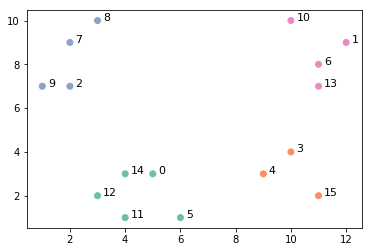

In [52]:
colors = ['#6AC1A6', '#E68CC2', '#8EA1CA', '#FA8D67']
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(clustered_data.iloc[:,2], clustered_data.iloc[:,3], c = [colors[i] for i in clustered_data.iloc[:,1].tolist()])

x = [i for i in clustered_data.iloc[:,2]]
y = [i for i in clustered_data.iloc[:,3]]
for i in range(clustered_data.shape[0]):
    ax.annotate(str(clustered_data.iat[i,0]), (x[i]+0.2, y[i]), color='black', fontsize = 11)

In [53]:
probability_table

,From,To,Weights
0,0.0,1.0,0.025664
1,0.0,2.0,0.102482
2,0.0,3.0,2184.113909
3,1.0,0.0,0.008384
4,1.0,2.0,0.031367
5,1.0,3.0,0.257918
6,2.0,0.0,4873.892965
7,2.0,1.0,0.025531
8,2.0,3.0,0.014781
9,3.0,0.0,0.088600


<p>Let's give a look at the succession of the best fit across the generations.</p>
<p>We can see a negative trend indicating that the algorithm "is learning" to generate new paths that can approximate the best solution.</p>

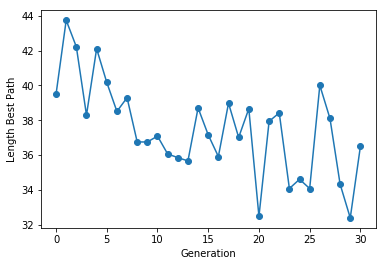

In [56]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(0,len(all_fit)), all_fit, marker = 'o')
ax.set_ylabel('Length Best Path')
ax.set_xlabel('Generation')
plt.show()